### Lorenz 96 chaos study

This notebook studies the dynamical behaviour of Lorenz'96 model for different levels of the forcing. This study is used to choose forcing for the imperfect model which results in a periodic orbit than a chaotic attractor.

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import odeint
import tensorflow_probability as tfp
import gc

##  Lorenz'96 Testcase:

The reference model is a two-level system of ODEs for $K$ large-scale
variables, each with $J$ small-scale components. The evolution equations for
large- and small-scale components ($X_k$s and $Y_j$s, respectively) are given as,

<h3>$\dfrac{dX_k}{dt} = -X_{k-1}(X_{k-2} - X_{k+1}) - X_k + F - hc\overline{Y}_k$ </h3>
<h3>$\dfrac{1}{c}\dfrac{dY_{j,k}}{dt} = -b Y_{j+1,k}(Y_{j+2,k} - Y_{j-1,k}) - Y_{j,k} + \dfrac{h}{J}X_k $</h3>

Here $h$ is the coupling constant, $c$ is the temporal scale ratio, and $b$ is the spatial scale ratio. The imperfect model is the set of equations corresponding to the large-scale
components only, i.e.,
<h3>$\dfrac{dX_j}{dt} = -X_{k-1}(X_{k-2} - X_{k+1}) - X_k + F $ </h3>

## System I: Perfect Model (Large + Small Scales)

In [2]:
# System I
def L96_twolevel(y,t,K=36,J=10,h=1,F=10,c=10,b=10):
    X = y[:K]
    Y = y[K:].reshape((J,K))
    dydt = np.zeros(y.shape)
    dydt[:K] = - np.roll(X,-1)*(np.roll(X,-2)-np.roll(X,1)) - X -(h*c)*np.mean(Y,axis=0) + F
    dydt[K:] = -c*(b*np.roll(Y,(1,0))*(np.roll(Y,(2,0))-np.roll(Y,(-1,0))) + Y - (h/J)*np.tile(X,(J,1))).reshape(K*J)
    return list(dydt)

In [3]:
# params
K = 8; J = 4;
h = 1; c = 10; b = 10 # default: b=10
t0 = 0
tend = t0+500
dt = 0.1
nt = int((tend-t0)/dt)
t = np.linspace(t0,tend,nt+1)

# Define a range of F
F_min = 1; F_max = 12; deltaF = 0.05; nF = round((F_max - F_min)/deltaF) + 1
F = np.linspace(F_min,F_max,nF)

# integrate the Lorenz models over t for all F
states_twolevel = np.zeros((len(t),K+K*J,len(F)))

for i in range(len(F)):
    print('F = ',F[i])
    
    # initialization
    np.random.seed(10)
    Xinit = np.random.normal(0.25*F[i],0.5*F[i],K) # resolved
    ss_init = np.random.normal(0,1,J*K) # unresolved
    Yinit = np.append(Xinit, ss_init) # resolved + unresolved
    # parameters
    args_twolevel = (K,J,h,F[i],c,b)
    # integrate
    states_twolevel[:,:,i] = odeint(L96_twolevel,Yinit,t,args=args_twolevel)

F =  1.0
F =  1.05
F =  1.1
F =  1.15
F =  1.2
F =  1.25
F =  1.3
F =  1.35
F =  1.4
F =  1.45
F =  1.5
F =  1.55
F =  1.6
F =  1.65
F =  1.7000000000000002
F =  1.75
F =  1.8
F =  1.85
F =  1.9
F =  1.9500000000000002
F =  2.0
F =  2.05
F =  2.1
F =  2.1500000000000004
F =  2.2
F =  2.25
F =  2.3
F =  2.35
F =  2.4000000000000004
F =  2.45
F =  2.5
F =  2.55
F =  2.6
F =  2.6500000000000004
F =  2.7
F =  2.75
F =  2.8
F =  2.85
F =  2.9000000000000004
F =  2.95
F =  3.0
F =  3.0500000000000003
F =  3.1
F =  3.15
F =  3.2
F =  3.25
F =  3.3000000000000003
F =  3.35
F =  3.4000000000000004
F =  3.45
F =  3.5
F =  3.5500000000000003
F =  3.6
F =  3.6500000000000004
F =  3.7
F =  3.75
F =  3.8000000000000003
F =  3.85
F =  3.9000000000000004
F =  3.95
F =  4.0
F =  4.050000000000001
F =  4.1
F =  4.15
F =  4.2
F =  4.25
F =  4.300000000000001
F =  4.35
F =  4.4
F =  4.45
F =  4.5
F =  4.550000000000001
F =  4.6
F =  4.65
F =  4.7
F =  4.75
F =  4.800000000000001
F =  4.85
F =  4.9
F =  4.

In [4]:
import netCDF4 as nc
try:ncfile.close()
except:pass  
ncfile = nc.Dataset('Lorenz96_twolevel_dF=0.05.nc',mode='w',format='NETCDF4')

# Add dimensions
nt = ncfile.createDimension('nt',None)
nF = ncfile.createDimension('nF',len(F))
nvar = ncfile.createDimension('nvar',K*J+K)

# Add attributes
ncfile.title='Lorenz 96 Model Data'
ncfile.anything = f"K = {K}, J = {J}, h = {h}, c = {c}, b = {b}" 

# Add variables
Fs = ncfile.createVariable('F', np.int32, ('nF',))
Fs.long_name = 'Forcing'

ts = ncfile.createVariable('t', np.int32, ('nt',))
ts.long_name = 'time'

states = ncfile.createVariable('states', np.float32, ('nt','nvar','nF'))
states.long_name = 'L96 states'

# write the data
Fs[:] = F  # using [:] is necessary for assignment, else nothing would be written
ts[:] = t
states[:,:,:] = states_twolevel

# close
ncfile.close()

### Visualize bifurcation for a large-scale variable (here, $X_1$)

In [21]:
# interpolation to increase the resolution in F
x_var = 0 # which x variable to visualize
# uncomment the below lines when interpolation is desired
#num_fine = 520
#F_fine = np.linspace(F_min,F_max,num_fine)
#states_fine = np.concatenate([np.interp(F_fine, F, y_row) for y_row in states_twolevel[:,x_var,:]])
#F_fine = np.broadcast_to(F_fine,(nt+1,num_fine)).ravel()

In [22]:
print('Max X1:',states_twolevel.max())
print('Min X1:',states_twolevel.min())

Max X1: 14.070228003465544
Min X1: -7.61917324217078


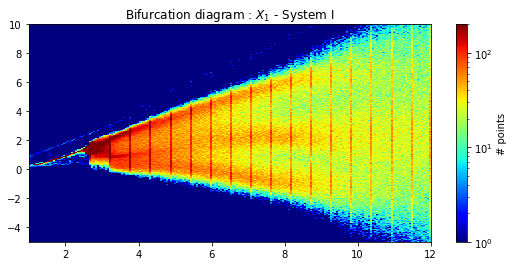

In [50]:
# plot states_twolevel_fine with log colorscale
cmap = plt.colormaps["jet"]
cmap = cmap.with_extremes(bad=cmap(0))
#h, xedges, yedges = np.histogram2d(F_fine,states_fine,bins=[200,500])

# uncomment the below three lines for plotting only the simulated data, not interpolated
F_mat = np.broadcast_to(F,(len(t),len(F))).ravel()
states_x = states_twolevel[:,x_var,:].ravel()
h, xedges, yedges = np.histogram2d(F_mat,states_x,bins=[200,400])

# Plot 
fig, ax = plt.subplots(1,1,figsize=(9,4))
norm = mpl.colors.LogNorm(vmin=1, vmax=200)
pcm = ax.pcolormesh(xedges, yedges, h.T, cmap=cmap, norm=norm, rasterized=True)
fig.colorbar(pcm, ax=ax, label="# points",)
ax.set_title(f"Bifurcation diagram : $X_1$ - System I")
ax.set_ylim(-5,10)
plt.show()

### Bifurcation for a small-scale variable

In [24]:
y_var = 0 
print('Max Y1:',np.max(states_twolevel[:,K+y_var,:],axis=(0,1)))
print('Min Y1:',np.min(states_twolevel[:,K+y_var,:],axis=(0,1)))

Max Y1: 2.206790313650631
Min Y1: -1.6258238108110878


In [60]:
#F_fine = np.linspace(F_min,F_max,num_fine)
#states_fine = np.concatenate([np.interp(F_fine, F, y_row) for y_row in states_twolevel[:,K+y_var,:]])
#F_fine = np.broadcast_to(F_fine,(nt+1,num_fine)).ravel()

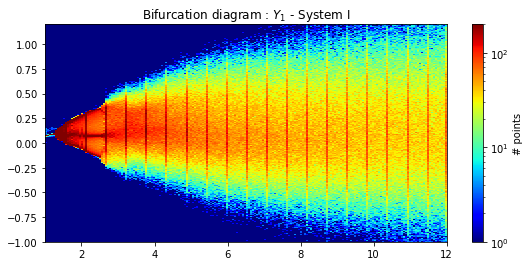

In [47]:
# plot states_twolevel_fine with log colorscale
cmap = plt.colormaps["jet"]
cmap = cmap.with_extremes(bad=cmap(0))
#h, xedges, yedges = np.histogram2d(F_fine,states_fine,bins=[200,400])
states_y = states_twolevel[:,K+y_var,:].ravel()
h, xedges, yedges = np.histogram2d(F_mat,states_y,bins=[200,400])

# Plot 
fig, ax = plt.subplots(1,1,figsize=(9,4))
norm = mpl.colors.LogNorm(vmin=1, vmax=200)
pcm = ax.pcolormesh(xedges, yedges, h.T, cmap=cmap, norm=norm, rasterized=True)
fig.colorbar(pcm, ax=ax, label="# points",)
ax.set_title(f"Bifurcation diagram : $Y_1$ - System I")
ax.set_ylim(-1,1.2)
plt.show()

### $X_2$ vs $X_1$

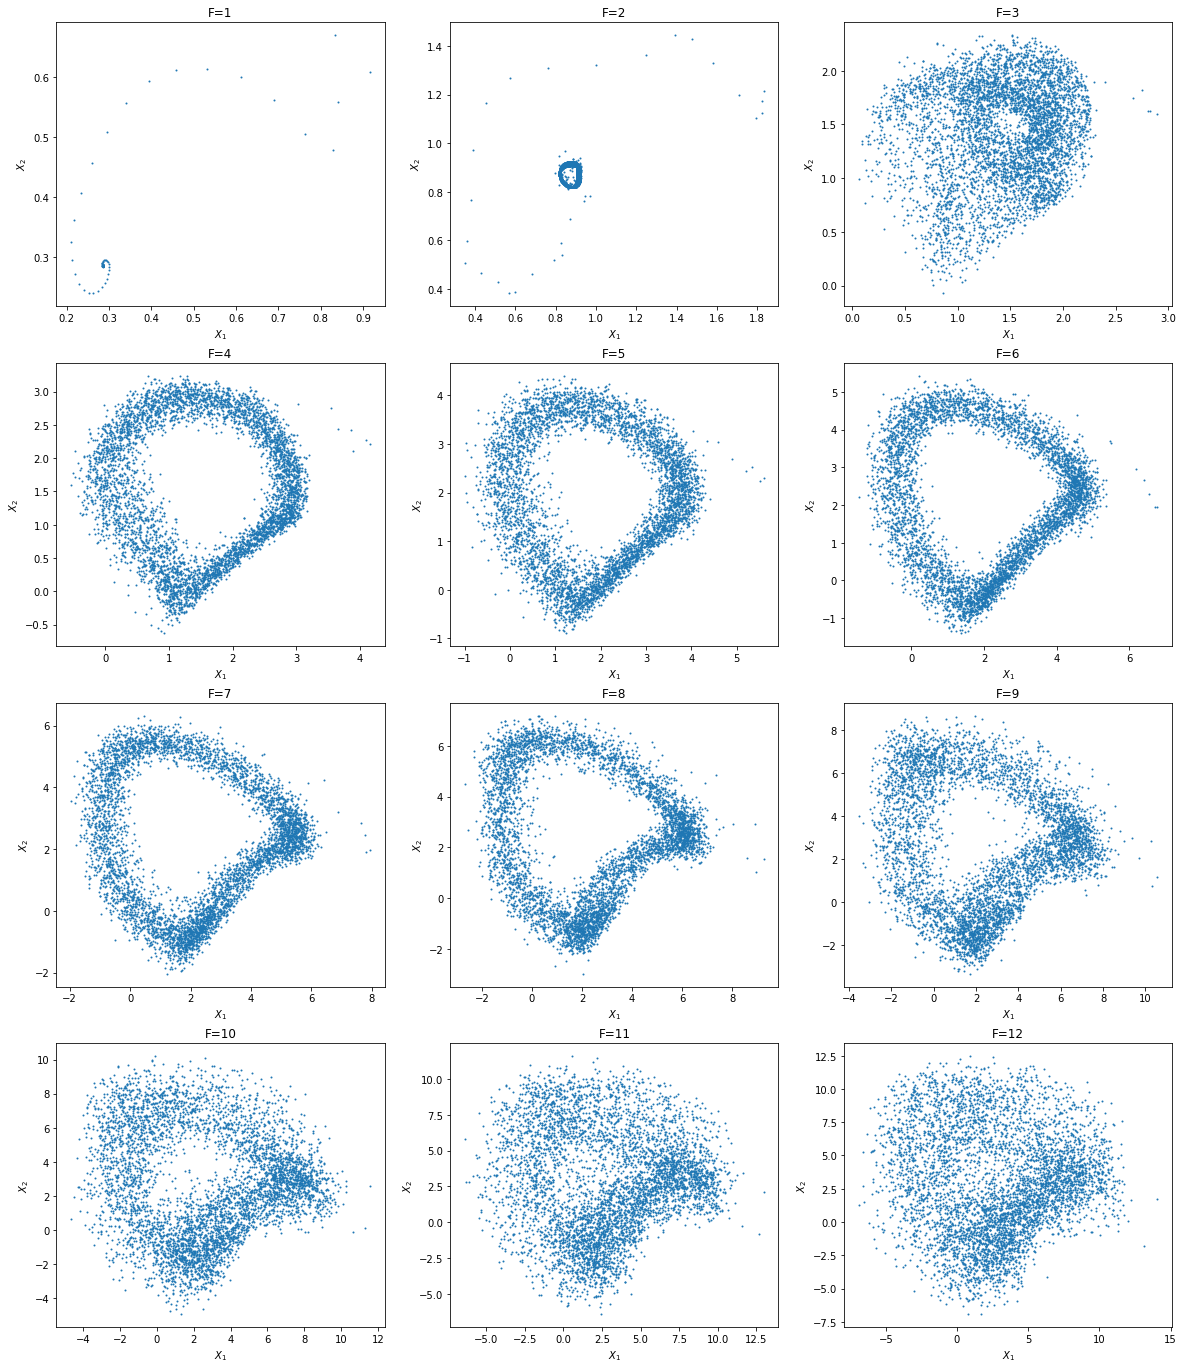

In [66]:
######## Plot X_2 vs X_1 trajectory #######
nrows = 4; ncols = 3
fig, ax = plt.subplots(4, 3, figsize=(20,24),)

for n in range(len(F)):
    i = int(n/ncols)
    j = int(n%ncols)
    ax[i][j].scatter(states_twolevel[:,0,n],states_twolevel[:,1,n],sizes=[1])
    #ax[i][j].plot(states_twolevel[:,0,n],states_twolevel[:,1,n], linewidth=0.2)
    ax[i][j].set_xlabel(f"$X_1$")
    ax[i][j].set_ylabel(f"$X_2$")
    ax[i][j].set_title(f"F={int(F[n])}")

plt.show()

### $Y_2$ vs $Y_1$

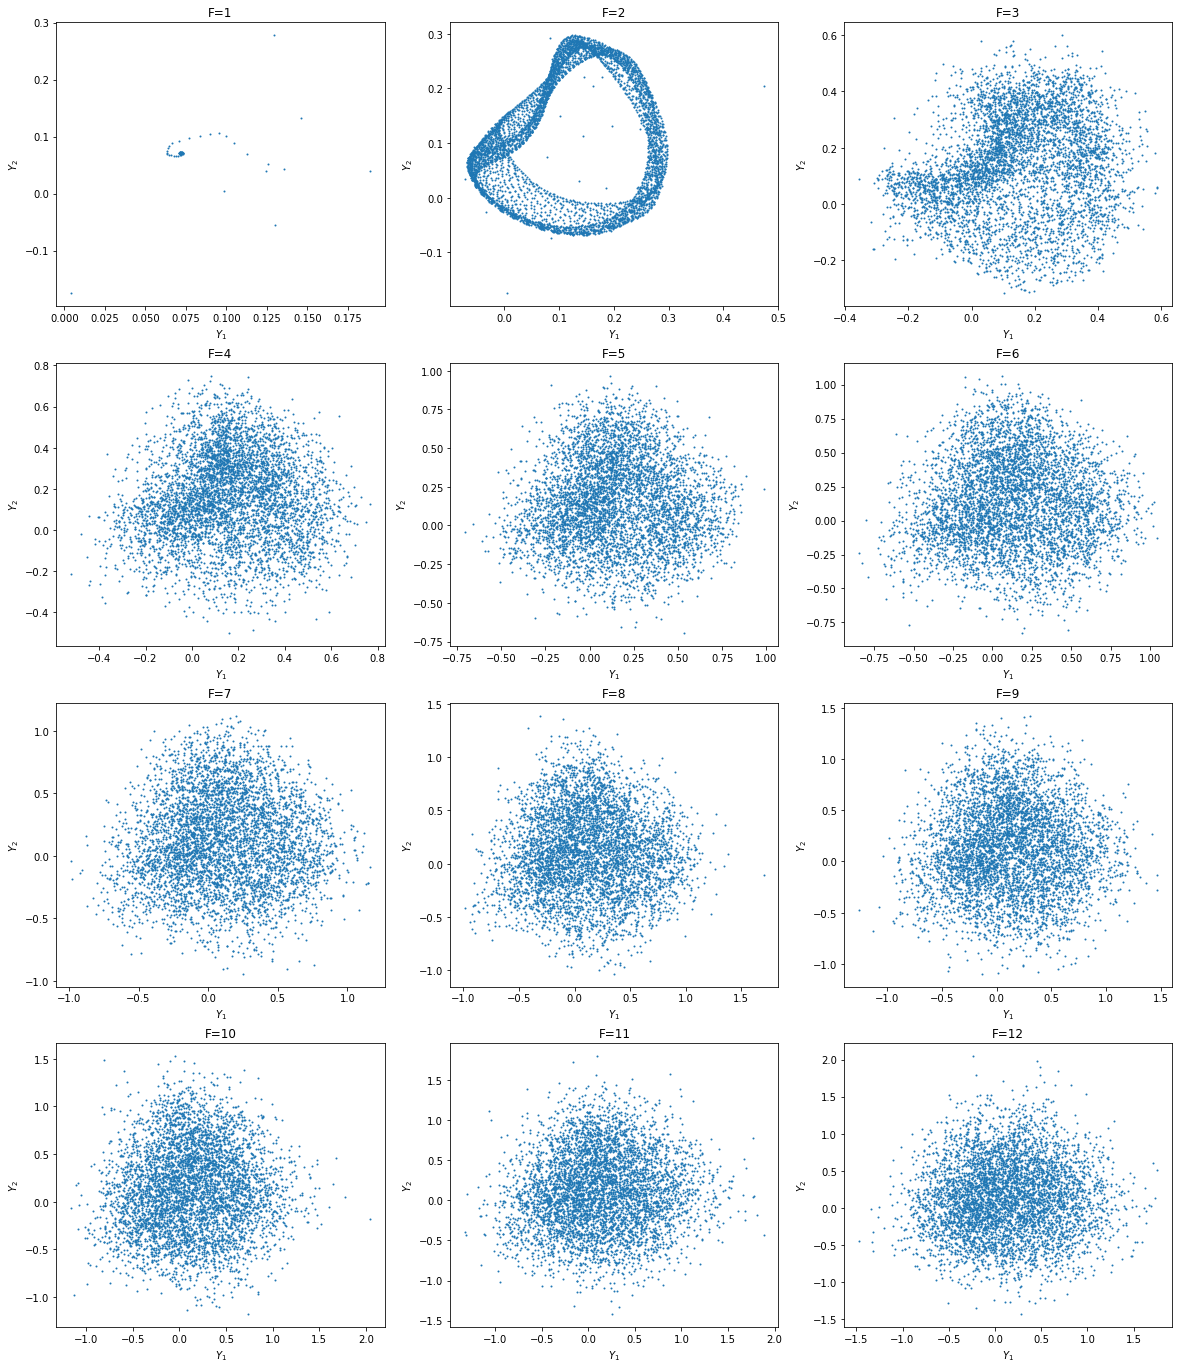

In [67]:
######## Plot Y_2 vs Y_1 trajectory #######
nrows = 4; ncols = 3
fig, ax = plt.subplots(4, 3, figsize=(20,24))

for n in range(len(F)):
    i = int(n/ncols)
    j = int(n%ncols)
    ax[i][j].scatter(states_twolevel[:,K,n],states_twolevel[:,K+1,n], sizes=[1])
    #ax[i][j].plot(states_twolevel[:,K,n],states_twolevel[:,K+1,n], linewidth=0.2)
    ax[i][j].set_xlabel(f"$Y_1$")
    ax[i][j].set_ylabel(f"$Y_2$")
    ax[i][j].set_title(f"F={int(F[n])}")

plt.show()

## System II: Imperfect Model (Large Scale only)

In [29]:
def L96_onelevel(y,t,F=10):
    dydt = -np.roll(y,-1)*(np.roll(y,-2)-np.roll(y,1)) - y + F
    return list(dydt)

In [30]:
# integrate over t for all F
states_onelevel = np.zeros((len(t),K,len(F)))

for i in range(len(F)):
    print('F = ',F[i])
    
    # initialization
    np.random.seed(10)
    Xinit = np.random.normal(0.25*F[i],0.5*F[i],K) # resolved
    # parameters
    args_onelevel = (F[i],)
    # integrate
    states_onelevel[:,:,i] = odeint(L96_onelevel,Xinit,t,args=args_onelevel)

F =  1.0
F =  1.05
F =  1.1
F =  1.15
F =  1.2
F =  1.25
F =  1.3
F =  1.35
F =  1.4
F =  1.45
F =  1.5
F =  1.55
F =  1.6
F =  1.65
F =  1.7000000000000002
F =  1.75
F =  1.8
F =  1.85
F =  1.9
F =  1.9500000000000002
F =  2.0
F =  2.05
F =  2.1
F =  2.1500000000000004
F =  2.2
F =  2.25
F =  2.3
F =  2.35
F =  2.4000000000000004
F =  2.45
F =  2.5
F =  2.55
F =  2.6
F =  2.6500000000000004
F =  2.7
F =  2.75
F =  2.8
F =  2.85
F =  2.9000000000000004
F =  2.95
F =  3.0
F =  3.0500000000000003
F =  3.1
F =  3.15
F =  3.2
F =  3.25
F =  3.3000000000000003
F =  3.35
F =  3.4000000000000004
F =  3.45
F =  3.5
F =  3.5500000000000003
F =  3.6
F =  3.6500000000000004
F =  3.7
F =  3.75
F =  3.8000000000000003
F =  3.85
F =  3.9000000000000004
F =  3.95
F =  4.0
F =  4.050000000000001
F =  4.1
F =  4.15
F =  4.2
F =  4.25
F =  4.300000000000001
F =  4.35
F =  4.4
F =  4.45
F =  4.5
F =  4.550000000000001
F =  4.6
F =  4.65
F =  4.7
F =  4.75
F =  4.800000000000001
F =  4.85
F =  4.9
F =  4.

In [32]:
try:ncfile.close()
except:pass  
ncfile = nc.Dataset('Lorenz96_onelevel_dF=0.05.nc',mode='w',format='NETCDF4')

# Add dimensions
nt = ncfile.createDimension('nt',None)
nF = ncfile.createDimension('nF',len(F))
nvar = ncfile.createDimension('nvar',K)

# Add attributes
ncfile.title='Lorenz 96 Model Data'
ncfile.anything = f"K = {K}, h = {h}, c = {c}, b = {b}" 

# Add variables
Fs = ncfile.createVariable('F', np.int32, ('nF',))
Fs.long_name = 'Forcing'

ts = ncfile.createVariable('t', np.int32, ('nt',))
ts.long_name = 'time'

states = ncfile.createVariable('states', np.float32, ('nt','nvar','nF'))
states.long_name = 'L96 states'

# write the data
Fs[:] = F  # using [:] is necessary for assignment, else nothing would be written
ts[:] = t
states[:,:,:] = states_onelevel

# close
ncfile.close()

In [33]:
x_var = 0 # which x variable to visualize
#num_fine = 260
#F_fine = np.linspace(F_min,F_max,num_fine)
#states_fine = np.concatenate([np.interp(F_fine, F, y_row) for y_row in states_onelevel[:,x_var,:]])
#F_fine = np.broadcast_to(F_fine,(nt+1,num_fine)).ravel()

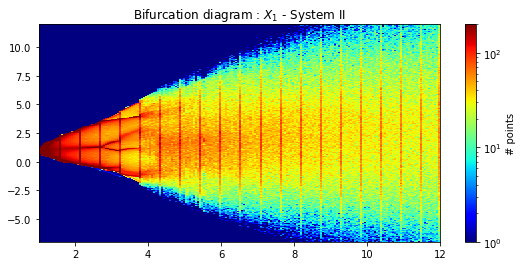

In [42]:
# plot states_twolevel_fine with log colorscale
cmap = plt.colormaps["jet"]
cmap = cmap.with_extremes(bad=cmap(0))
states_x = states_onelevel[:,x_var,:].ravel()
h, xedges, yedges = np.histogram2d(F_mat,states_x,bins=[200,400])
#h, xedges, yedges = np.histogram2d(F_fine,states_fine,bins=[200,500])

# Plot 
fig, ax = plt.subplots(1,1,figsize=(9,4))
norm = mpl.colors.LogNorm(vmin=1, vmax=200)
pcm = ax.pcolormesh(xedges, yedges, h.T, cmap=cmap, norm=norm, rasterized=True)
fig.colorbar(pcm, ax=ax, label="# points",)
ax.set_title(f"Bifurcation diagram : $X_1$ - System II")
ax.set_ylim(-7,12)
plt.show()

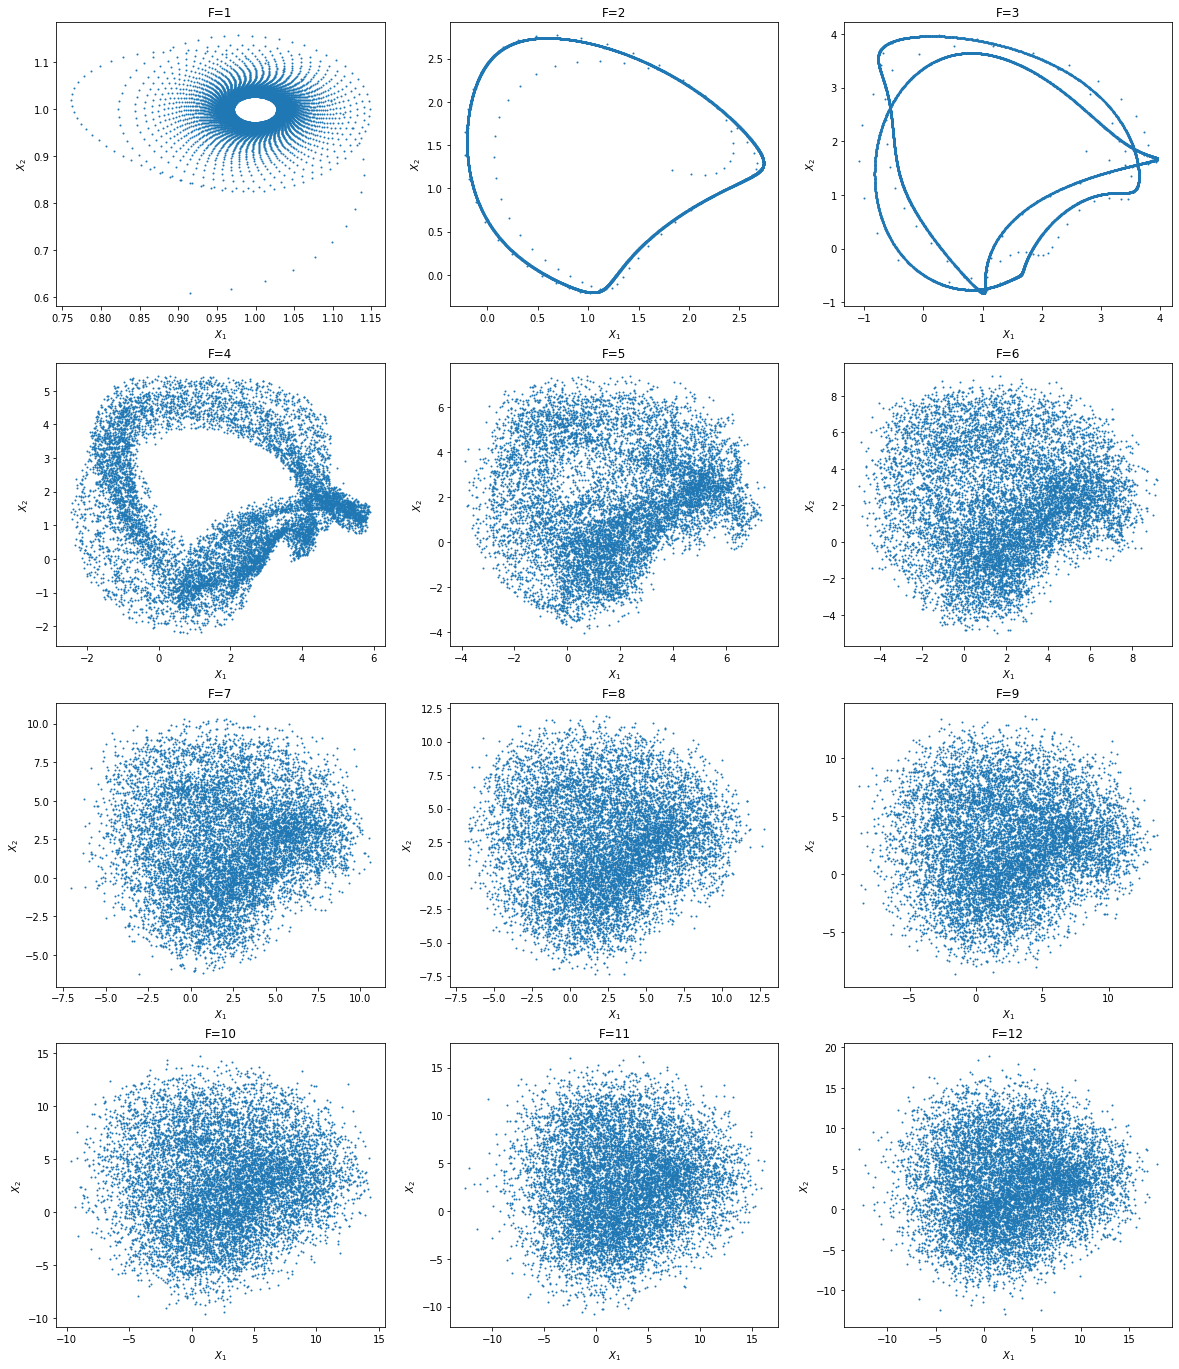

In [141]:
######## Plot X_2 vs X_1 trajectory #######
nrows = 4; ncols = 3
fig, ax = plt.subplots(4, 3, figsize=(20,24),)

for n in range(len(F)):
    i = int(n/ncols)
    j = int(n%ncols)
    ax[i][j].scatter(states_onelevel[:,0,n],states_onelevel[:,1,n],sizes=[1])
    #ax[i][j].plot(states_twolevel[:2000,0,n],states_twolevel[:2000,1,n], linewidth=0.2)
    ax[i][j].set_xlabel(f"$X_1$")
    ax[i][j].set_ylabel(f"$X_2$")
    ax[i][j].set_title(f"F={int(F[n])}")
plt.show()